# Loading Libraries, the Model and Writing Feature Extraction Helper Function

In [1]:
import numpy as np
import tensorflow as tf
import skimage
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

from tensorflow.keras.applications.vgg16 import VGG16
# VGG16 was a model architecture that ranked REALLY WELL in a 2014 machine vision object recognition competion

# Details at: https://keras.io/applications/#vgg16
model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling='max', classes=1000)



def format_image(img:np.array)->np.array:
    '''Converts the image into the format that is expected by the pre-trained model'''
    resized_img = skimage.transform.resize(img, (224, 224, 3), mode='reflect', anti_aliasing=True)
    formated_img = resized_img.reshape(1, *resized_img.shape)
    return formated_img


def extract_features(image:np.array, model=model)->np.array:
    formated_image = format_image(image)
    image_features = model.predict(formated_image).ravel()
    return image_features


# Capturing images with Open CV and using the Feature Extraction from VGG16

#Here we area creating a list of "Image Frames" where I look happy, and extracting the VGG16 features

cap = cv2.VideoCapture(0)

happy = []
for i in range(20):
    try:
        # Capture frame-by-frame
        ret, frame = cap.read()

        plt.imshow(frame.mean(axis=2), cmap='gray')
        plt.show()

        features = extract_features(frame)
        happy.append(features)

        time.sleep(1)
    except:
        print('Stoped')

cap = cv2.VideoCapture(0)

sad = []


for i in range(20):
    # Capture frame-by-frame
    
    try:
        ret, frame = cap.read()

        plt.imshow(frame.mean(axis=2), cmap='gray')
        plt.show()

        features = extract_features(frame)
        sad.append(features)

        time.sleep(1)
    except:
        print('Stoped')

# Making a DataFrame for Training

df_happy = pd.DataFrame(happy).assign(target = 'Happy')
df_sad = pd.DataFrame(sad).assign(target = 'Sad')

df = pd.concat([df_happy, df_sad])

df.head()

# Loading from disk just in case

In [3]:
df = pd.read_csv('happy_sad.csv').drop(['Unnamed: 0'], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,target
0,1.317196,0.000000,0.613930,0.363425,1.220333,0.0,1.650221,1.302684,0.399058,0.146537,...,0.874446,0.715958,0.554085,0.625149,1.033700,0.208336,0.789042,1.033700,0.0,Happy
1,1.488492,0.000000,0.756040,0.359960,1.083577,0.0,1.775071,1.198040,0.938583,0.363334,...,0.902159,0.873070,0.853550,0.680130,0.986976,0.236965,0.716586,1.073829,0.0,Happy
2,1.558022,0.000000,0.606882,0.507376,1.174315,0.0,1.522977,1.285222,0.254929,0.193182,...,0.733771,0.811947,0.741557,0.673411,1.038159,0.283347,0.308612,1.085167,0.0,Happy
3,2.087281,0.327485,0.766129,0.384416,1.242960,0.0,1.714872,1.604714,0.295242,0.239654,...,0.748889,0.838244,0.509212,0.810890,1.021062,0.180793,0.687938,1.060327,0.0,Happy
4,1.697815,0.090359,0.650592,0.277037,1.209168,0.0,1.711340,1.474924,0.193696,0.351661,...,0.810304,0.670218,0.324994,0.714916,1.035868,0.206279,0.800277,1.066648,0.0,Happy


# EDA

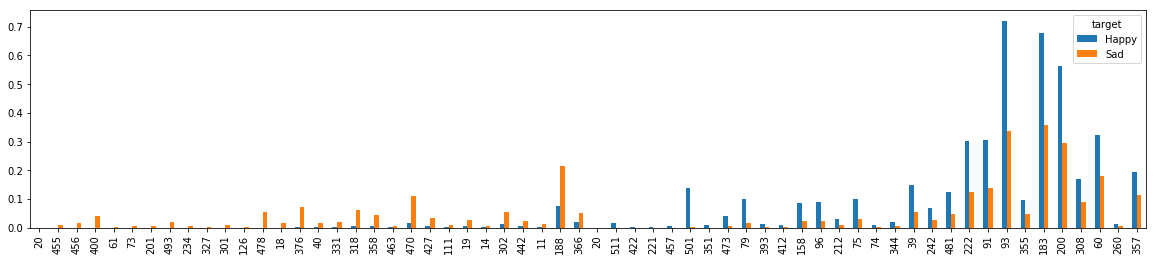

In [4]:
(df
 .groupby('target')
 .mean()
 .T
 .assign(diff = lambda x: (x['Happy']-x['Sad'])/(x['Happy']+x['Sad']))
 .sort_values(by='diff')
 .dropna()
 .drop('diff', axis=1)
 .iloc[list(range(30)) + [-x for x in range(30)],:].plot(kind='bar', figsize=(20,4))
)

# ML

In [5]:
from sklearn.preprocessing import StandardScaler

X = df.drop('target', axis=1)
y = df['target']

In [6]:
X_scaled = StandardScaler().fit_transform(X)

In [7]:
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_2d_projection

pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

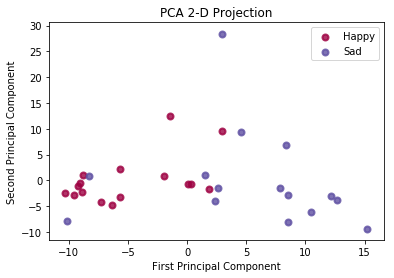

In [8]:
plot_pca_2d_projection(pca, X_scaled, y)

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rfc = ExtraTreesClassifier(max_depth=2, n_estimators=1500)

cross_val_score(rfc, X_scaled, y, cv=5, n_jobs=5).mean()

0.8476190476190476